# 🔬 Leukocytes images classification using Vision Transformers

***

## 📁 Set up the environment

#### Installing dependencies

In [ ]:
!pip install -q wandb
!pip install -q datasets transformers
!pip install -q plotly-express

     |████████████████████████████████| 1.9 MB 13.9 MB/s 
     |████████████████████████████████| 182 kB 66.0 MB/s 
     |████████████████████████████████| 174 kB 65.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 173 kB 57.8 MB/s 
     |████████████████████████████████| 168 kB 65.8 MB/s 
     |████████████████████████████████| 168 kB 31.0 MB/s 
     |████████████████████████████████| 166 kB 58.0 MB/s 
     |████████████████████████████████| 166 kB 59.9 MB/s 
     |████████████████████████████████| 162 kB 64.9 MB/s 
     |████████████████████████████████| 162 kB 56.0 MB/s 
     |████████████████████████████████| 158 kB 62.6 MB/s 
     |████████████████████████████████| 157 kB 67.2 MB/s 
     |████████████████████████████████| 157 kB 24.4 MB/s 
     |████████████████████████████████| 157 kB 63.7 MB/s 
     |████████████████████████████████| 157 kB 37.7 MB/s 
     |████████████████████████████████| 157 kB 70.0 MB/s 
     |██████████

#### Importing libraries and logging

In [ ]:
from huggingface_hub import notebook_login


notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
import wandb


wandb.login()


PROJECT = "lcbsi-vits-sweeps"
ENTITY = "polejowska"

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from datasets import load_dataset, load_metric
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
)
import numpy as np
from tqdm import tqdm

from PIL import Image
import requests

import zipfile
from io import BytesIO
import gdown
import tensorflow as tf
from tensorflow import keras

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")

## 📚 Loading the dataset



In [ ]:
from datasets import load_dataset


dataset_path = "lcbsi-wbc-ap"
dataset = load_dataset(f"polejowska/{dataset_path}")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/750 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/3500 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/polejowska___parquet/polejowska--lcbsi-wbc-ap-35876f5f55923258/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

#### Upload dataset to W&B

In [ ]:
dataset.save_to_disk("lcbsi-wbc-ap")

In [ ]:
# log the dataset to wandb as an artifact
with wandb.init(project=PROJECT, entity=ENTITY, job_type="upload") as run:
  artifact = wandb.Artifact("lcbsi-wbc-ap", type="dataset")
  artifact.add_dir(dataset_path)
  run.log_artifact(artifact)
  run.name = "dataset-upload"

wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (./lcbsi-wbc-ap)... Done. 0.1s


In [ ]:
# run = wandb.init(project=PROJECT, entity=ENTITY, job_type="download")
# artifact = run.use_artifact('polejowska/lcbsi-wbc-monai-ai/raw_data:v0', type='dataset')
# artifact_dir = artifact.download()
# dataset_path = "artifacts/raw_data-v0"
# run.finish()

wandb: Downloading large artifact raw_data:v0, 34.94MB. 5002 files... 
wandb:   5002 of 5002 files downloaded.  
Done. 0:1:36.8


In [ ]:
# dataset = load_dataset("imagefolder", data_files={"train": "/content/artifacts/raw_data-v0/train/**", "test": "artifacts/raw_data-v0/test/**", "valid": "artifacts/raw_data-v0/valid/**"})

## 🔍 Explore the dataset

In [ ]:
print(f"Dataset structure: {dataset}\n")
print(f"Number of training examples: {len(dataset['train'])}\n")
print(f"Dataset sample (image, label): {dataset['train'][0]}\n")
print(f"Dataset features: {dataset['train'].features}\n")
print(f"Class labels: {dataset['train'].features['label'].names}\n")

Dataset structure: DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3500
    })
})

Number of training examples: 3500

Dataset sample (image, label): {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F92305B9130>, 'label': 0}

Dataset features: {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'], id=None)}

Class labels: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']



In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

#### Visualize data and display essential information

In [ ]:
def plot_class_distribution(dataset, id2label, dataset_name="dataset"):
    fig = px.histogram(
        x=[id2label[label] for label in dataset["label"]],
        title=f"Distribution of classes in the {dataset_name}",
    )
    fig.update_layout(xaxis_title="Class", yaxis_title="Number of examples")
    fig.show()
    return fig

In [ ]:
train_dataset_fig = plot_class_distribution(dataset["train"], id2label, "train")
valid_dataset_fig = plot_class_distribution(dataset["valid"], id2label, "valid")
test_dataset_fig = plot_class_distribution(dataset["test"], id2label, "test")

In [ ]:
def display_random_images(dataset, label2id, id2label):
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        random_image = np.random.randint(0, len(dataset))
        image = dataset[random_image]["image"]
        label = dataset[random_image]["label"]
        class_name = id2label[label]

        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(image)
        ax.set_title(f"Class: {label} ({class_name})")
        ax.axis("off")
    plt.show()
    return fig

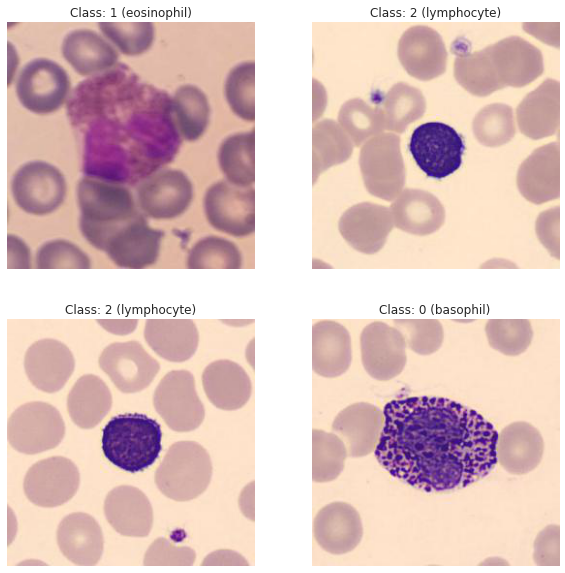

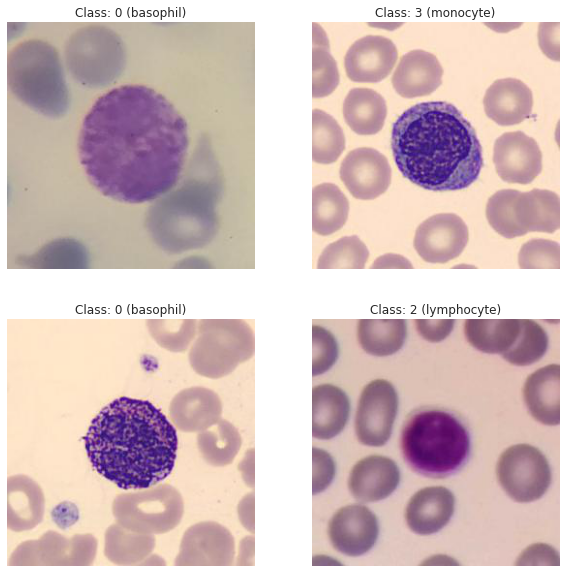

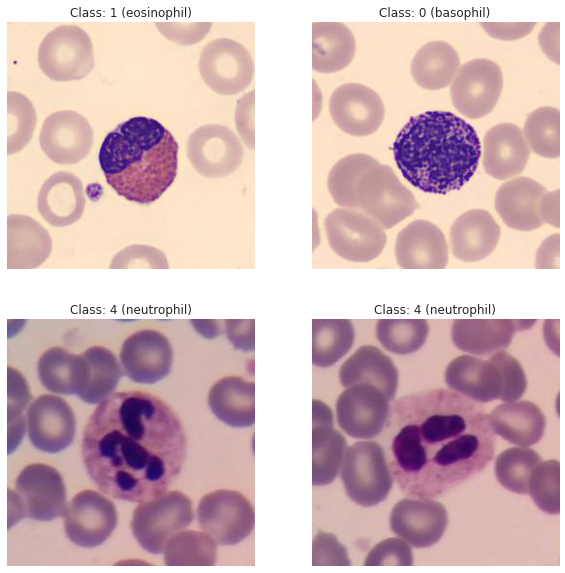

In [ ]:
random_images_train = display_random_images(dataset["train"], label2id, id2label)
random_images_valid = display_random_images(dataset["valid"], label2id, id2label)
random_images_test = display_random_images(dataset["test"], label2id, id2label)

#### Log to W&B dataset tables and dataset information

In [ ]:
def create_table(dataset):
    table = wandb.Table(columns=["image", "label", "class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label])

    return table

In [ ]:
import pandas as pd


with wandb.init(project=PROJECT, entity=ENTITY, job_type="dataset-info") as run:
    run.log({"train-distribution": train_dataset_fig})
    run.log({"valid-distribution": valid_dataset_fig})
    run.log({"test-distribution": test_dataset_fig})
    run.log({"train-random-images": random_images_train})
    run.log({"valid-random-images": random_images_valid})
    run.log({"test-random-images": random_images_test})
    # class labels
    run.log({"class-labels": wandb.Table(dataframe=pd.DataFrame.from_dict(id2label, orient="index", columns=["class-labels"]))})
    # number of training examples
    run.log({"number-of-training-examples": len(dataset["train"])})
    # number of validation examples
    run.log({"number-of-validation-examples": len(dataset["valid"])})
    # number of test examples
    run.log({"number-of-test-examples": len(dataset["test"])})
    run.name = "dataset-info"

    train_dataset_table = create_table(dataset["train"])
    valid_dataset_table = create_table(dataset["valid"])
    test_dataset_table = create_table(dataset["test"])

    run.log({"train-dataset": train_dataset_table})
    run.log({"valid-dataset": valid_dataset_table})
    run.log({"test-dataset": test_dataset_table})



100%|██████████| 750/750 [00:18<00:00, 41.33it/s]


number-of-test-examples,▁
number-of-training-examples,▁
number-of-validation-examples,▁
number-of-test-examples,750
number-of-training-examples,3500
number-of-validation-examples,750


***
## 🔨 Data preparation

1. Resize images
2. Normalize RGB channels using mean and standard deviation

In [ ]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
# model_checkpoint = "facebook/convnext-tiny-224"
# model_checkpoint = "google/vit-base-patch16-224-in21k"
# model_checkpoint = "nickmuchi/vit-base-xray-pneumonia"


feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/255 [00:00<?, ?B/s]

In [ ]:
data_transforms = Compose(
        [
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ]
    )


def add_pixel_values_feature(batch):
  batch["pixel_values"] = [
        data_transforms(image.convert("RGB")) for image in batch["image"]
  ]
  return batch


datasets_processed = dataset.rename_column('label', 'labels')

In [ ]:
train_dataset = datasets_processed["train"].map(add_pixel_values_feature, batched=True)
validation_dataset = datasets_processed["valid"].map(add_pixel_values_feature, batched=True)
test_dataset = datasets_processed["test"].map(add_pixel_values_feature, batched=True)

print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(validation_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Length of training dataset: 3500
Length of validation dataset: 750
Length of test dataset: 750


#### Upload processed dataset to W&B

In [ ]:
train_dataset.save_to_disk("train_dataset")
validation_dataset.save_to_disk("validation_dataset")
test_dataset.save_to_disk("test_dataset")

Saving the dataset (0/5 shards):   0%|          | 0/3500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/750 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/750 [00:00<?, ? examples/s]

In [ ]:
!mv train_dataset dataset/
!mv validation_dataset dataset/
!mv test_dataset dataset/

mv: cannot move 'validation_dataset' to 'dataset/validation_dataset': Directory not empty
mv: cannot move 'test_dataset' to 'dataset/test_dataset': Directory not empty


In [ ]:
with wandb.init(project=PROJECT, entity=ENTITY, job_type="upload-processed-dataset") as run:
    artifact = wandb.Artifact("processed-dataset", type="dataset")
    artifact.add_dir("dataset")
    run.log_artifact(artifact)
    run.name = "dataset-processed-upload"

wandb: Adding directory to artifact (./dataset)... Done. 19.0s


#### Additional dataset transformation

In [ ]:
train_dataset.set_transform(add_pixel_values_feature)
validation_dataset.set_transform(add_pixel_values_feature)
test_dataset.set_transform(add_pixel_values_feature)

***
## Model configuration and training

In [ ]:
def init_model():
    model = AutoModelForImageClassification.from_pretrained(
        model_checkpoint, 
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,
    )
    return model

In [ ]:
def compute_metrics_fn(eval_preds):
  metrics = dict()
  
  accuracy_metric = load_metric('accuracy')
  precision_metric = load_metric('precision')
  recall_metric = load_metric('recall')
  f1_metric = load_metric('f1')

  logits = eval_preds.predictions
  labels = eval_preds.label_ids
  preds = np.argmax(logits, axis=-1)  
  
  metrics.update(accuracy_metric.compute(predictions=preds, references=labels))
  metrics.update(precision_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(recall_metric.compute(predictions=preds, references=labels, average='weighted'))
  metrics.update(f1_metric.compute(predictions=preds, references=labels, average='weighted'))

  return metrics


In [ ]:
def collate_fn(examples):
  pixel_values = torch.stack([example['pixel_values'] for example in examples])
  labels = torch.tensor([example['labels'] for example in examples])
  return {'pixel_values': pixel_values, 'labels': labels}

In [ ]:
def create_table_with_predictions(dataset, predictions):
    table = wandb.Table(columns=["image", "label", "class name", "prediction", "prediction class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["labels"]
        table.add_data(wandb.Image(image), label, id2label[label], predictions[i], id2label[predictions[i]])

    return table

In [ ]:
def plot_confusion_matrix(cm, class_names):
    fig = go.Figure(data=go.Heatmap(z=cm, x=class_names, y=class_names))
    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted label",
        yaxis_title="True label",
        annotations=[go.layout.Annotation(
            text=str(round(z, 2)), x=x, y=y, font_size=14, showarrow=False) 
        for x, y, z in zip(
            np.tile(class_names, len(class_names)), np.repeat(class_names, len(class_names)), cm.flatten())],
            )
    fig.show()
    return fig

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, accuracy_score


def train(config=None):
  with wandb.init(config=config, project=PROJECT, entity=ENTITY) as run:
    config = wandb.config

    artifact = run.use_artifact("processed-dataset:latest")

    training_args = TrainingArguments(
        output_dir='vit_train',
        report_to='wandb',
        num_train_epochs=config.epochs,
        learning_rate=config.learning_rate,
        weight_decay=config.weight_decay,
        per_device_train_batch_size=config.batch_size,
        per_device_eval_batch_size=16,
        save_strategy='epoch',
        evaluation_strategy='epoch',
        logging_strategy='epoch',
        load_best_model_at_end=True,
        remove_unused_columns=False,
    )

    trainer = Trainer(
        model_init=init_model,
        args=training_args,
        data_collator=collate_fn,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        compute_metrics=compute_metrics_fn
    )

    trainer.train()
    trainer.evaluate()

    test_predictions = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
    test_table_with_predictions = create_table_with_predictions(test_dataset, test_predictions)
    run.log({"test_dataset_table_with_predictions": test_table_with_predictions})

    confusion_matrix_plot = wandb.plot.confusion_matrix(
        probs=None,
        y_true=test_dataset[:]["labels"],
        preds=test_predictions,
        class_names=list(id2label.values()),
    )
    run.log({"confusion_matrix": confusion_matrix_plot})

    test_accuracy = accuracy_score(test_dataset[:]["labels"], test_predictions)
    run.log({f"Test dataset accuracy": wandb.Html(f"""<h1 style="text-align: center;">{round(test_accuracy*100, 3)}%</h1>""")})

    cm = confusion_matrix(test_dataset[:]["labels"], test_predictions)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm_plot = plot_confusion_matrix(cm, list(id2label.values()))
    run.log({"confusion_matrix (plotly)": cm_plot})

    trainer.save_state()

    model_name = model_checkpoint.split("/")[-1] + "_trained"

    model_artifact = wandb.Artifact(model_name, type='model')
    model_artifact.add_dir('vit_train')
    run.log_artifact(model_artifact)

#### Traditional model training

In [ ]:
# https://wandb.ai/polejowska/lcbsi-vits-sweeps/sweeps/v1hzdxlf

best_config_from_sweep = {
    'learning_rate': 0.0002562,
    'weight_decay': 0.5,
    'batch_size': 32
}

best_config_from_sweep['epochs'] = 10

train(best_config_from_sweep)

wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


Downloading:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_heads": [
    3,
    6,
    12,

Downloading:   0%|          | 0.00/113M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/pytorch_model.bin
All model checkpoint weights were used when initializing SwinForImageClassification.

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478400,0.254781,0.913333,0.925561,0.913333,0.912020
2,0.156700,0.282355,0.946667,0.955134,0.946667,0.947536
3,0.101600,0.100627,0.978667,0.979640,0.978667,0.978653
4,0.073000,0.042727,0.993333,0.993324,0.993333,0.993324
5,0.040400,0.106592,0.972000,0.973589,0.972000,0.972250
6,0.027500,0.082516,0.984000,0.984599,0.984000,0.983983
7,0.014900,0.087849,0.985333,0.985604,0.985333,0.985297
8,0.004100,0.083667,0.988000,0.988060,0.988000,0.987981
9,0.002000,0.098393,0.989333,0.989411,0.989333,0.989315
10,0.001200,0.094058,0.989333,0.989411,0.989333,0.989315


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
<ipython-input-13-fb946481973b>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')


Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-330
Configuration saved in vit_train/checkpoint-330/config.json
Model weights saved in vit_train/checkpoint-330/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-440
Configuration saved in vit_train/checkpoint-440/config.json
Model weights saved in vit_train/checkpoint-440/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving m

***** Running Prediction *****
  Num examples = 750
  Batch size = 16
100%|██████████| 750/750 [02:09<00:00,  5.78it/s]


wandb: Adding directory to artifact (./vit_train)... Done. 23.7s


eval/accuracy,▁▄▇█▆▇▇████
eval/f1,▁▄▇█▆▇▇████
eval/loss,▇█▃▁▃▂▂▂▃▂▁
eval/precision,▁▄▇█▆▇▇▇███
eval/recall,▁▄▇█▆▇▇████
eval/runtime,▄█▃▃▂▃▂▄▂▂▁
eval/samples_per_second,▅▁▆▆▇▆▇▅▇▇█
eval/steps_per_second,▅▁▆▆▇▆▇▅▇▇█
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████████
train/learning_rate,█▇▆▆▅▄▃▃▂▁


In [ ]:
with wandb.init(project=PROJECT, job_type="save_model") as run:
    model_name = f"best_model_{model_checkpoint.split('/')[-1]}"
    
    model_artifact = wandb.Artifact(model_name, type='model')
    model_artifact.add_file('vit_train/checkpoint-440/pytorch_model.bin')
    wandb.log_artifact(model_artifact)

#### Sweep configuration

In [ ]:
sweep_config = {
    'method': 'bayes'
}

metric = {
    'name': 'eval/loss',
    'goal': 'minimize'   
}

sweep_config['metric'] = metric


# hyperparameters
parameters_dict = {
    'epochs': {
        'value': 5
        },
    'batch_size': {
        'values': [8, 16, 32, 64]
        },
    'learning_rate': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 1e-3
    },
    'weight_decay': {
        'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    },
}


sweep_config['parameters'] = parameters_dict


PROJECT = "lcbsi-vits-sweeps"
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: v1hzdxlf
Sweep URL: https://wandb.ai/polejowska/lcbsi-vits-sweeps/sweeps/v1hzdxlf


In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: dumauimq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	learning_rate: 1.3222768895958748e-05
wandb: 	weight_decay: 0.4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.164200,0.629354,0.808000,0.821709,0.808000,0.804046
2,0.381800,0.227908,0.925333,0.929122,0.925333,0.925155
3,0.183100,0.132429,0.961333,0.962482,0.961333,0.961391
4,0.132500,0.099272,0.970667,0.971304,0.970667,0.970639
5,0.109000,0.096292,0.970667,0.971304,0.970667,0.970639


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-55
Configuration saved in vit_train/checkpoint-55/config.json
Model weights saved in vit_train/checkpoint-55/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-165
Configuration saved in vit_train/checkpoint-165/config.json
Model weights saved in vit_train/checkpoint-165/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Runni

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▆████
eval/f1,▁▆████
eval/loss,█▃▁▁▁▁
eval/precision,▁▆████
eval/recall,▁▆████
eval/runtime,▄▁█▃▂▂
eval/samples_per_second,▅█▁▆▇▇
eval/steps_per_second,▅█▁▆▇▇
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▄▃▁


wandb: Agent Starting Run: mgdf36k3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.00025620061145057604
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.604100,0.218635,0.925333,0.930791,0.925333,0.924973
2,0.190000,0.068528,0.978667,0.979243,0.978667,0.978641
3,0.081500,0.136383,0.972000,0.972846,0.972000,0.971852
4,0.042300,0.047586,0.992000,0.992026,0.992000,0.992004
5,0.016000,0.059575,0.992000,0.992000,0.992000,0.992000


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-330
Configuration saved in vit_train/checkpoint-330/config.json
Model weights saved in vit_train/checkpoint-330/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-440
Configuration saved in vit_train/checkpoint-440/config.json
Model weights saved in vit_train/checkpoint-440/pytorch_model.bin
***** Ru

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▇▆███
eval/f1,▁▇▆███
eval/loss,█▂▅▁▁▁
eval/precision,▁▇▆███
eval/recall,▁▇▆███
eval/runtime,▆▁█▃▇▅
eval/samples_per_second,▃█▁▆▂▄
eval/steps_per_second,▃█▁▆▂▄
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▅▃▁


wandb: Agent Starting Run: 349t74e7 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 1.0813458829979476e-05
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.000200,0.450518,0.868000,0.875378,0.868000,0.867753
2,0.269700,0.165357,0.953333,0.954381,0.953333,0.953006
3,0.139800,0.094355,0.973333,0.974110,0.973333,0.973279
4,0.096100,0.079981,0.981333,0.981539,0.981333,0.981304
5,0.075700,0.075224,0.980000,0.980170,0.980000,0.979948


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-330
Configuration saved in vit_train/checkpoint-330/config.json
Model weights saved in vit_train/checkpoint-330/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-440
Configuration saved in vit_train/checkpoint-440/config.json
Model weights saved in vit_train/checkpoint-440/pytorch_model.bin
***** Ru

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▆████
eval/f1,▁▆████
eval/loss,█▃▁▁▁▁
eval/precision,▁▆████
eval/recall,▁▆████
eval/runtime,▁▂▂▄█▄
eval/samples_per_second,█▇▇▅▁▅
eval/steps_per_second,█▇▇▅▁▅
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▅▃▁


wandb: Agent Starting Run: vz51wchq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0002930694611065378
wandb: 	weight_decay: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.711000,0.151614,0.965333,0.967084,0.965333,0.965386
2,0.186100,0.104299,0.974667,0.975050,0.974667,0.974592
3,0.087000,0.103843,0.973333,0.974177,0.973333,0.973320
4,0.063200,0.079378,0.984000,0.984110,0.984000,0.983972
5,0.015000,0.063277,0.989333,0.989323,0.989333,0.989306


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-110
Configuration saved in vit_train/checkpoint-110/config.json
Model weights saved in vit_train/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-220
Configuration saved in vit_train/checkpoint-220/config.json
Model weights saved in vit_train/checkpoint-220/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-330
Configuration saved in vit_train/checkpoint-330/config.json
Model weights saved in vit_train/checkpoint-330/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-440
Configuration saved in vit_train/checkpoint-440/config.json
Model weights saved in vit_train/checkpoint-440/pytorch_model.bin
***** Ru

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▄▃▆██
eval/f1,▁▄▃▆██
eval/loss,█▄▄▂▁▁
eval/precision,▁▄▃▆██
eval/recall,▁▄▃▆██
eval/runtime,▅▁▆▂█▄
eval/samples_per_second,▄█▃▇▁▅
eval/steps_per_second,▄█▂▇▁▅
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▄▄▆▆████
train/learning_rate,█▆▅▃▁


wandb: Agent Starting Run: teivjn4z with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 1.2377323646536083e-05
wandb: 	weight_decay: 0.5


PyTorch: setting up devices
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/config.json
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-tiny-patch4-window7-224",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "basophil",
    "1": "eosinophil",
    "2": "lymphocyte",
    "3": "monocyte",
    "4": "neutrophil"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "basophil": 0,
    "eosinophil": 1,
    "lymphocyte": 2,
    "monocyte": 3,
    "neutrophil": 4
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "swin",
  "num_channels": 3,
  "num_hea

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.556200,0.086360,0.973333,0.973537,0.973333,0.973180
2,0.133600,0.072178,0.981333,0.981536,0.981333,0.981201
3,0.079300,0.101305,0.981333,0.981694,0.981333,0.981281
4,0.059300,0.066456,0.985333,0.985521,0.985333,0.985327
5,0.038400,0.079010,0.982667,0.982928,0.982667,0.982622


***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-438
Configuration saved in vit_train/checkpoint-438/config.json
Model weights saved in vit_train/checkpoint-438/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-876
Configuration saved in vit_train/checkpoint-876/config.json
Model weights saved in vit_train/checkpoint-876/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-1314
Configuration saved in vit_train/checkpoint-1314/config.json
Model weights saved in vit_train/checkpoint-1314/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 750
  Batch size = 16
Saving model checkpoint to vit_train/checkpoint-1752
Configuration saved in vit_train/checkpoint-1752/config.json
Model weights saved in vit_train/checkpoint-1752/pytorch_model.bin
**

***** Running Prediction *****
  Num examples = 750
  Batch size = 16


eval/accuracy,▁▆▆█▆█
eval/f1,▁▆▆█▆█
eval/loss,▅▂█▁▄▁
eval/precision,▁▆▆█▆█
eval/recall,▁▆▆█▆█
eval/runtime,▆█▁▅▇▄
eval/samples_per_second,▃▁█▄▂▅
eval/steps_per_second,▃▁█▄▂▅
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆████
train/learning_rate,█▆▅▃▁


## Inference using transformers pipeline

In [ ]:
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image

img_url = 'https://huggingface.co/spaces/polejowska/LCBSI/resolve/main/95-8-24-1_190_1.jpg'
image = load_image_from_url(img_url)

In [ ]:
from transformers import pipeline


repo_name = "polejowska/swin-tiny-patch4-window7-224-lcbsi-wbc"
pipe = pipeline("image-classification", repo_name)

Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/388 [00:00<?, ?B/s]

In [ ]:
pipe(image)

[{'score': 0.9994284510612488, 'label': 'monocyte'},
 {'score': 0.00023444283579010516, 'label': 'eosinophil'},
 {'score': 0.00017420583753846586, 'label': 'basophil'},
 {'score': 0.00015998473099898547, 'label': 'lymphocyte'},
 {'score': 2.8791891963919625e-06, 'label': 'neutrophil'}]

In [ ]:
wandb.finish()

W&B report: https://wandb.ai/polejowska/vit-classification-lcbsi/reports/Leukocytes-classification-from-blood-smear-images--VmlldzozMTU1NjI0